## Problem: K-Mean clustering of heart disease factors 
## Data: Heart disease dataset from the UC Irvine Machine Learni
### Having consistency across samples when choosing the number of clusters and the clustering algorithms is an important perormance goal. Unlike the cross-validation and test/re-test methods for supervised learning, there's no formal metric for assessing how "similar" clusters are between different data subsets. To explore this consistency issue, we'll compare two-, three-, and four-cluster solutions for the dataset. We'll be using k-means algorithm and dividing the data into two samples of equal size. Our goal will be to determine which k value optimizes consistency across the two samples.
#### We will measure Rand Index, Adjusted Rand Index and Silhouette Coefficients

In [6]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.patches import Patch
import matplotlib.patches as patches
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")
from numpy import percentile
from numpy.random import seed
import os
import datetime
from sqlalchemy import create_engine
import scipy
from scipy.special import comb

In [7]:
import sklearn.datasets
from sklearn import decomposition
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
import sklearn.metrics as metrics
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [8]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_colwidth', -1) 

In [9]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [10]:
# Extrat from remote database and save for local access
#path = 'c:\\Analytics\\education_pipeline\\data'
path = 'c:\\Users\\User\\OneDrive - Seedergy\\MAEN\\dev_data\\1st_project\\thinkful'
os.chdir(path)

export_location = os.path.join(path, 'heartdisease.csv') ### File


def to_csv(self, path, index=True, sep=",", na_rep='', float_format=None,
           header=False, index_label=None, mode='w', nanRep=None,
           encoding=None, date_format=None, decimal='.'):
    """
    Write Series to a comma-separated values (csv) file
    ...
    """
    from pandas.core.frame import DataFrame
    df = DataFrame(self)
    # result is only a string if no path provided, otherwise None
    result = df.to_csv(path, index=index, sep=sep, na_rep=na_rep,
                       float_format=float_format, header=header,
                       index_label=index_label, mode=mode, nanRep=nanRep,
                       encoding=encoding, date_format=date_format,
                       decimal=decimal)
    if path is None:
        return result

In [12]:
#path1 = 'c:\\Analytics\\ITM_Pipeline\\Step3a_Query\\Step3a_Data'
#path1 = 'c:\\Users\\00233270\\dev\\sandbox\\thinkful\\data'
path1 = 'c:\\Users\\User\\OneDrive - Seedergy\\MAEN\\dev_data\\1st_project\\thinkful'
os.chdir(path1)
heartdisease_df_file = os.path.join(path1, 'heartdisease.csv')     ### File
heartdisease_df = pd.read_csv(heartdisease_df_file)  

In [13]:
# Make sure the number of rows divides evenly into four samples.
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]
df = df.replace(to_replace='?', value=0)

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13].astype(float)

# Replace some random string values.
#X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

In [14]:
# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)


In [15]:
# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

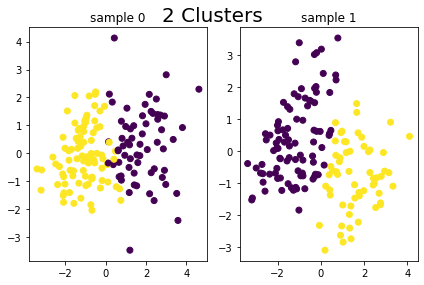

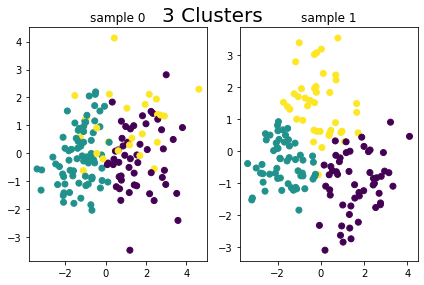

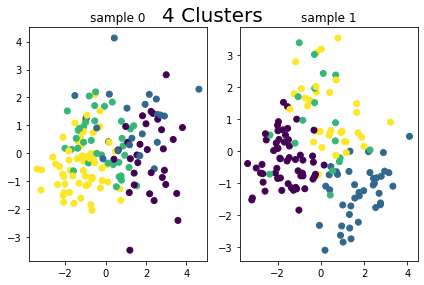

In [16]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [17]:
def rand_index_score(grount_truths, predictions):
    tp_plus_fp = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    tp_plus_fn = scipy.special.comb(np.bincount(grount_truths), 2).sum()
    A = np.c_[(grount_truths, predictions)]
    tp = sum(scipy.special.comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(grount_truths))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = scipy.special.comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)


for k in range (2,5):
    #labels = KMeans(n_clusters=s, random_state=123).fit_predict(X_std)
    # Get predicted clusters.
    full_pred = KMeans(n_clusters=k, random_state=123).fit_predict(X_std)
    print("Rand Index (RI) score for k={} is: {}".format(k, rand_index_score(full_pred,y)))
    print("Adjusted Rand Index (ARI) for k={} is: {}".format(k, metrics.adjusted_rand_score(y, full_pred)))
    print("Silhouette coefficients fork={} is: {}".format(k, metrics.silhouette_score(X_std, full_pred, metric='euclidean')))
    print("----------------------------------------------")


    #print(metrics.silhouette_score(X_std, labels, metric='euclidean'))
    #f"result {full_pred}"
    #print(full_pred)
    

Rand Index (RI) score for k=2 is: 0.9867989703196849
Adjusted Rand Index (ARI) for k=2 is: 0.00033579575714130024
Silhouette coefficients fork=2 is: 0.15425182047520095
----------------------------------------------
Rand Index (RI) score for k=3 is: 0.9914193307077952
Adjusted Rand Index (ARI) for k=3 is: 0.0031559122590659595
Silhouette coefficients fork=3 is: 0.15864292922080145
----------------------------------------------
Rand Index (RI) score for k=4 is: 0.9951596224505511
Adjusted Rand Index (ARI) for k=4 is: 0.0031350295785462262
Silhouette coefficients fork=4 is: 0.12149853698952943
----------------------------------------------
